## Session 6


Convolutional Autoencoder

In [1]:
import torch
import torchvision.datasets as dsets
import torch.nn as nn
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from model import Encoder, Decoder, LogisticRegression
from evaluator import ModelEvaluator, AutoEncoderEvaluator

## Use latent features to train and test a simple MLP

In [2]:
def load_model(model_name, key='state_dict_encoder'):
    model_dir = '../Session6/model/' + model_name
    checkpoint = torch.load(model_dir)
    checkpoint = checkpoint[key]
    return checkpoint

In [3]:
# Set Hyperparameters
epochs = 10
batch_size = 10
lr = 0.001
# Model
l2 = 0.0
optim = 'adam'
model_epoch = 8
use_gpu= True
cudnn.benchmark = True

model_name = 'AutoEncoder_lr_{}_opt_{}_epoch_{}'.format(lr, optim, model_epoch)

encoder = Encoder(batch_size=batch_size)
decoder = Decoder(batch_size=batch_size)

encoder.load_state_dict(load_model(model_name, key='state_dict_encoder'))
decoder.load_state_dict(load_model(model_name, key='state_dict_decoder'))

In [4]:
encoder.eval()

Encoder(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05

In [5]:
decoder.eval()

Decoder(
  (layer1): Sequential(
    (0): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=

In [6]:
from matplotlib import pyplot as plt

Files already downloaded and verified
Files already downloaded and verified
Actual Input


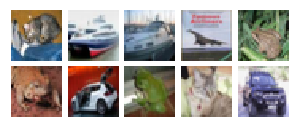

Reconstructed Output


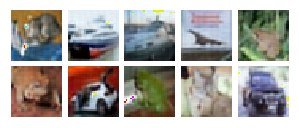

In [7]:
trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

def plot_img(tensor, num_cols=5):
  num_imgs = tensor.shape[0]
  num_rows = 1+ num_imgs // num_cols
  fig = plt.figure(figsize=(num_cols,num_rows))
  for i in range(num_imgs):
    ax1 = fig.add_subplot(num_rows,num_cols,i+1)
    ax1.imshow(tensor[i].transpose((1, 2, 0)))
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show() 

for images, labels in testloader:
    output = encoder.forward(images)
    output = decoder.forward(output)
    break

print('Actual Input')
plot_img(images.detach().cpu().numpy())
print('Reconstructed Output')
plot_img(output.detach().cpu().numpy())   

In [19]:
import numpy as np
from tqdm import tqdm

In [ ]:
add_noise = False
'''
n_in = 32768  # 512x8x8
n_hidden = 128
n_out = 10
model_epochs = 20
model_lr = 0.001
l2 = 0.0

#train classifier
model = LogisticRegression(n_in, n_hidden, n_out)
modeleval = ModelEvaluator(model, model_epochs, model_lr, l2=l2, use_gpu=True, optim='adam')
acc_ = modeleval.evaluator(encoder, trainloader, testloader, noise=add_noise, print_every=100)
'''
n_in = 32768  # 512x8x8
train_features_ = np.zeros([len(trainset), n_in])
train_labels_ = np.zeros(len(trainset))
for b_idx, (train_data, train_labels) in tqdm(enumerate(trainloader)):
    latent_repr = encoder.forward(train_data)
    train_features_[b_idx: b_idx+batch_size,:] = latent_repr.detach().cpu().numpy()
    train_labels_[b_idx: b_idx+batch_size] = train_labels.detach().cpu().numpy()

1292it [05:17,  4.07it/s]

In [ ]:
test_features_ = np.zeros([len(testset), n_in])
test_features_ = np.zeros(len(testset))
for b_idx, (test_data, test_labels) in enumerate(testloader):
    latent_repr = encoder.forward(train_data)
    test_features_[b_idx: b_idx+batch_size,:] = latent_repr.detach().cpu().numpy()
    test_labels_[b_idx: b_idx+batch_size] = test_labels.detach().cpu().numpy()

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

predict_labels = OneVsRestClassifier(LinearSVC(random_state=0)).fit(train_features_, train_labels_).predict(test_features_)
print(classification_report(test_labels_, predict_labels))

## Denoising AutoEncoder

Add noise to encoder

In [ ]:
# Set Hyperparameters
epochs = 10
batch_size = 50
lr = 0.001
l2 = 0.0
optim = 'adam'
model_epoch = 10
model_name = 'AutoEncoder_lr_{}_opt_{}_epoch_{}_dae'.format(lr, optim, model_epoch)

encoder = Encoder(batch_size=batch_size)
decoder = Decoder(batch_size=batch_size)

encoder.load_state_dict(load_model(model_name, key='state_dict_encoder'))
decoder.load_state_dict(load_model(model_name, key='state_dict_decoder'))

In [ ]:
encoder.eval()

In [ ]:
decoder.eval()

In [ ]:
trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)


for images, labels in testloader:
    output = encoder.forward(images)
    images_n = torch.mul(images+0.25, 0.1 * torch.rand(batch_size, 3, 32, 32))
    output = decoder.forward(image_n)
    break

print('Actual Images')
plot_img(images.detach().cpu().numpy())
print('Input Images')
plot_img(images_n.detach().cpu().numpy())

print('Reconstructed Output')
plot_img(output.detach().cpu().numpy())   

In [ ]:
add_noise = True
train_features_ = np.zeros([len(trainset), n_in])
train_labels_ = np.zeros(len(trainset))
for b_idx, (train_data, train_labels) in enumerate(trainloader):
    train_data_n = torch.mul(train_data+0.25, 0.1 * torch.rand(batch_size, 3, 32, 32))
    latent_repr = encoder.forward(train_data_n)

    train_features_dn[b_idx: b_idx+batch_size,:] = latent_repr.detach().cpu().numpy()
    train_labels_dn[b_idx: b_idx+batch_size] = train_labels.detach().cpu().numpy()

In [ ]:
test_features_dn = np.zeros([len(testset), n_in])
test_labels_dn = np.zeros(len(testset))
for b_idx, (test_data, test_labels) in enumerate(testloader):
    latent_repr = encoder.forward(train_data)
    test_features_[b_idx: b_idx+batch_size,:] = latent_repr.detach().cpu().numpy()
    test_labels_[b_idx: b_idx+batch_size] = test_labels.detach().cpu().numpy()

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

predict_labels = OneVsRestClassifier(LinearSVC(random_state=0)).fit(train_features_, train_labels_).predict(test_features_)
print(classification_report(test_labels_, predict_labels))

## Get latent features from Soccer Dataset and train a logistic regression classifier

In [ ]:
from test_soccer import run_trainer, test_img
from soccer_dataset import SoccerDataset

In [ ]:
def get_soccer_latent(encoder):
    dataset = SoccerDataset(transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=3)
    transform = transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    n_in = 32768  # 512x8x8
    train_features_ = np.zeros([len(dataset), n_in])
    train_labels_ = np.zeros(len(dataset))
    
    for b_idx, (train_data, train_labels) in enumerate(trainloader):
        train_data_n = torch.mul(train_data+0.25, 0.1 * torch.rand(batch_size, 3, 32, 32))
        latent_repr = encoder.forward(train_data_n)

        train_features_soc[b_idx: b_idx+batch_size,:] = latent_repr.detach().cpu().numpy()
        train_labels_soc[b_idx: b_idx+batch_size] = train_labels.detach().cpu().numpy()
    return train_features_soc, train_labels_soc

In [ ]:
# Set Hyperparameters
epochs = 10
batch_size = 50
lr = 0.001
l2 = 0.0
optim = 'adam'
model_epoch = 10
model_name = 'AutoEncoder_lr_{}_opt_{}_epoch_{}_dae'.format(lr, optim, model_epoch)

encoder = Encoder(batch_size=batch_size)
decoder = Decoder(batch_size=batch_size)

encoder.load_state_dict(load_model(model_name, key='state_dict_encoder'))
decoder.load_state_dict(load_model(model_name, key='state_dict_decoder'))

In [ ]:
train_features_soc, train_labels_soc = get_soccer_latent(encoder)

model =  LinearSVC(random_state=0)
model = model.fit(train_features_soc, train_labels_soc)

predict_labels_soc = model.predict(test_features_soc)
print(classification_report(train_labels_soc, predict_labels_soc))

In [ ]:
def test_img(path, encoder, model):
    img = Image.open(path)
    plt.imshow(img)
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    img = transform(img)
    img = img.numpy()
    img = img[np.newaxis, ...]
    img = torch.Tensor(img)

    encoder.eval()

    with torch.no_grad():
        latent_repr = encoder.forward(img)
        latent_repr = latent_repr.detach().cpu().numpy()
        output = model.predict(latent_repr)
        print('prediction: {}'.format(['not soccer', 'soccer'][output])

## Test classifier on new images

In [ ]:
test_path = 'Session6/SoccerData/test'
img1_path = test_path + '/test1.jpg'
test_img(img1_path, encoder, model)